# Modern Data Analytics [G0Z39a]

## Project: Covid 19 in the USA

The current study is dedicated to analyze the evolution of Covid-19 pandemic in the US.

More specifically we aim to investigate the effect of the pandemic in a holistic approach.

Our goal is to provide insights by using visual tools and exploiting different statistical approaches and machine learning methods.

In [131]:
##Load packages
import mda_module_011 as mda

import os
import pandas as pd
import numpy as np

import yfinance as yf

import plotly.graph_objs as go
import plotly.io as pio
import plotly.express as px

import plotly.offline as py
py.init_notebook_mode(connected=True)
# jupyter notebook: notebook
#jupyter lab: plotly_mimetype
pio.renderers.default = 'plotly_mimetype' 
  
import matplotlib.pyplot as plt

import datetime as dt

import ipywidgets as widgets
from IPython.display import display
from IPython.display import Markdown as md

from sklearn.compose import ColumnTransformer 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')

### Load data
The data used here was mainly retrieved from the New York Times and can be found at https://github.com/thibtd/covid-19-data. We also make use of extra datasets:
-  Vaccination data  (https://data.cdc.gov/Vaccinations/COVID-19-Vaccinations-in-the-United-States-County/8xkx-amqh) 
-  Population data (https://data.cdc.gov/Vaccinations/COVID-19-Vaccinations-in-the-United-States-County/8xkx-amqh)
-  Geographic location data (https://www.kaggle.com/datasets/washimahmed/usa-latlong-for-state-abbreviations)

In [2]:
cwd = os.getcwd()
us = pd.read_csv(cwd+"/covid-19-data/us.csv")
counties_df = pd.read_csv(cwd+"/covid-19-data/us-counties.csv")
states_df = pd.read_csv(cwd+"/covid-19-data/us-states.csv")
counties20 = pd.read_csv(cwd+"/covid-19-data/us-counties-2020.csv")
counties21 = pd.read_csv(cwd+"/covid-19-data/us-counties-2021.csv")
counties22 = pd.read_csv(cwd+"/covid-19-data/us-counties-2022.csv")
extra_data = pd.read_csv(cwd+"/data/extra_data.csv")
dfpop = pd.read_csv(cwd+'/data/pop_usa_states.csv')

### Data Pre-Processing

In [3]:
counties20_clean = mda.counties_preprocessing(counties20)
counties21_clean = mda.counties_preprocessing(counties21)
counties22_clean = mda.counties_preprocessing(counties22)

The data pre-processing step is done as follow:
- We were able to fill in some of the missing values with information found online such as FIPS codes for the states. However the data that still had missing information was removed.
- The dates were split into year, month and day in order to simplify later analysis steps.

### Data Statistics
Here you can see all the descirptive statistics per states and per counties for each different years during the pandemic. As well as some other interesting finds that came out of those descriptive statistics.

In [4]:
# group the cleaned data by state and county to be able to get summary statistics.
perstate20 = mda.per_state(counties20_clean)
perstate21 = mda.per_state(counties21_clean)
perstate22 = mda.per_state(counties22_clean)
percounty20 = mda.per_county(counties20_clean)
percounty21 = mda.per_county(counties21_clean)
percounty22 = mda.per_county(counties22_clean)

In [5]:
state_stats20 = pd.DataFrame(counties20_clean.groupby('state').describe())
state_stats21 = pd.DataFrame(counties21_clean.groupby('state').describe())
state_stats22 = pd.DataFrame(counties22_clean.groupby('state').describe())

In [6]:
county_stats20 = pd.DataFrame(counties20_clean.groupby('county').describe())
county_stats21 = pd.DataFrame(counties21_clean.groupby('county').describe())
county_stats22 = pd.DataFrame(counties22_clean.groupby('county').describe())

In [7]:
dropdown_state_year = widgets.Dropdown(options=[("Counties in 2020", 'county_stats20'),
                                                ("Counties in 2021", 'county_stats21'), 
                                                ("Counties in 2022", 'county_stats22'),
                                              ("States in 2020", 'state_stats20'),
                                                ("States in 2021", 'state_stats21'),
                                               ("States in 2022", 'state_stats22')],
                                      description = 'Statistics for')
out = widgets.Output()
def desc_filter(change):
    out.clear_output()
    with out:
        if change == 'county_stats20':
            display(county_stats20)
        elif change == 'county_stats21':
            display(county_stats21)
        elif change == 'county_stats22':
            display(county_stats22)
        elif change == 'state_stats20':
            display(state_stats20)
        elif change == 'state_stats21':
            display(state_stats21)
        else:
            display(state_stats22)
    
def dropdown_state_year_eventhandler(change):
    desc_filter(change.new)

    
dropdown_state_year.observe(dropdown_state_year_eventhandler, names='value')

display(dropdown_state_year)
display(out)

#initial plot
with out:
    display(county_stats20)
    
    
    
    

Dropdown(description='Statistics for', options=(('Counties in 2020', 'county_stats20'), ('Counties in 2021', '…

Output()

Note: The above statistical measures are bases on the he initial data form the New York Times repository that are cumulative.

In [8]:
#time_series preprocessing 
us_timeseries = mda.timeseries_process(us, "us")
state_timeseries = mda.timeseries_process(states_df, "state")
counties = pd.concat([counties20_clean, counties21_clean, counties22_clean])
counties_timeseries = mda.timeseries_process(counties, "county")

In [9]:
dfpop.rename(columns={"State":"state"},inplace=True)
dfstates = pd.merge(state_timeseries, dfpop[['state','Pop']], how="left", on="state")

In [10]:
#state with the highest total cases, deaths 
h_c_state = dfstates[dfstates['cases']==dfstates['cases'].max()]
date = h_c_state['date'].dt.strftime('%Y-%m-%d').values[0]
state = h_c_state['state'].values[0]
cases = h_c_state['cases'].values[0]
h_d_state = dfstates[dfstates['deaths']==dfstates['deaths'].max()]
date_d = h_d_state['date'].dt.strftime('%Y-%m-%d').values[0]
state_d = h_d_state['state'].values[0]
deaths = h_c_state['deaths'].values[0]
md('The state that has the most cases as of {} is {} with a total of {} cases.'.format(date,state,cases))


The state that has the most cases as of 2022-05-28 is California with a total of 9557347 cases.

In [11]:
md('The state that has the most deaths as of {} is {} with a total of {} deaths.'.format(date_d,state_d,deaths))

The state that has the most deaths as of 2022-05-29 is California with a total of 91463 deaths.

In [12]:
last_upd = us_timeseries.iloc[-1]
tot_cases = last_upd['cases']
tot_deaths = last_upd['deaths']
date = last_upd['date'].strftime('%Y-%m-%d')
md('As of {}, {} people were tested positive and {} people died of COVID-19 in the US.'.format(date,tot_cases,tot_deaths))

As of 2022-05-29, 83931049 people were tested positive and 1003167 people died of COVID-19 in the US.

In addition to looking at descriptive statistics we decided to look into the cause-specific mortality ratio (CSR) as well as the case to fatality ratio (CFR).
- The CSR measures the mortality rate from a specified cause (COVID-19 in our case) for a population and is computed as $\mu_{CSR}= \frac{D_{\Delta T}}{P_{\Delta T}}\times n$, with n =1000 to normalize per thousand people, $D_{\Delta T}$ is the death count during the time interval $\Delta T$ and $P_{\Delta T}$ is the population size during the same time interval. 
- The CFR is the proportion of people with a condition (COVID-19) who died from that condition. It is a measure of the severity of the disease. It is computed as $\mu_{CFR}= \frac{D_{\Delta T}}{C_{\Delta T}}\times n$, with n=100 to have a proportion (\%), and $C_{\Delta T}$ is the number of (infected) cases during the same measuring time interval $\Delta T$.


In the following two figures $\Delta T$ is from the first day in the dataset until 2020-12-15, which is the first vaccination date.

Cause-specific mortality ratio per 1000 people in the US on 2020-12-15: 0.923 Per 1000 people

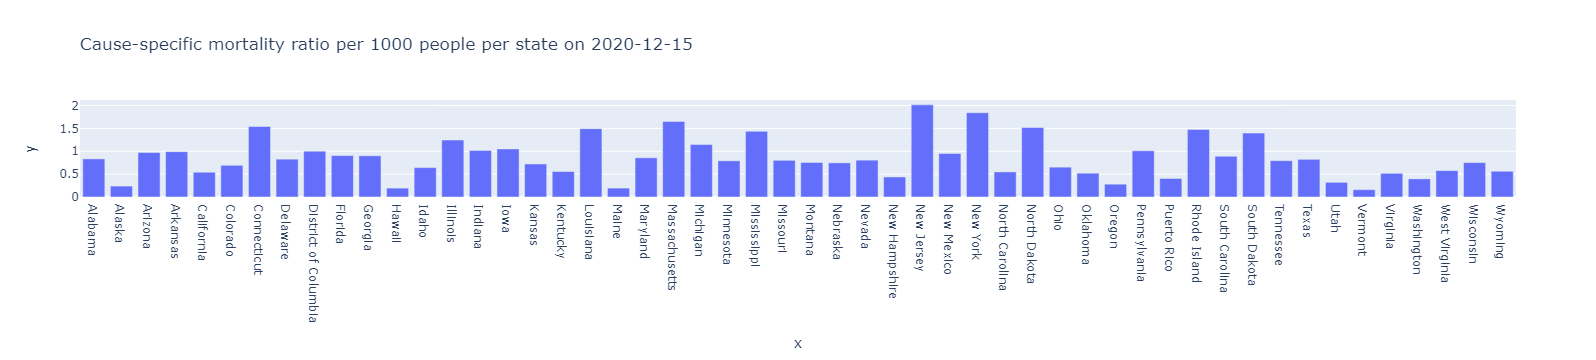

Case to fatality ratio in percent in the US on 2020-12-15: 1.813 %

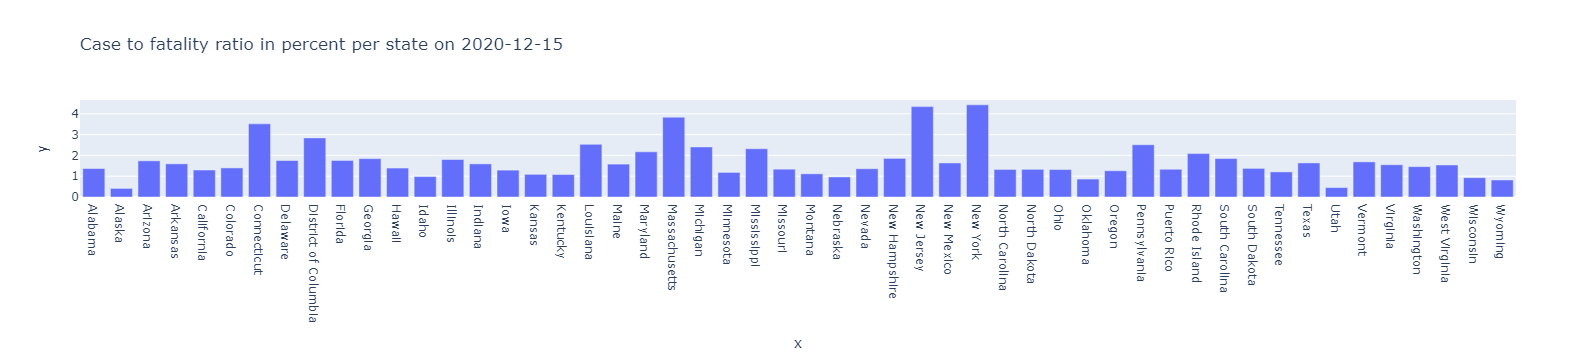

In [13]:
date = '2020-12-15'
csr_us= mda.comp_csr(us_timeseries,date,state=False)
cfr_us =mda.comp_cfr(us_timeseries,date,state=False)
display(md('Cause-specific mortality ratio per 1000 people in the US on {}: {} Per 1000 people'.format(date, csr_us)))
mda.comp_csr(dfstates,date)


display(md('Case to fatality ratio in percent in the US on {}: {} %'.format(date,cfr_us)))
mda.comp_cfr(dfstates,date)

In [14]:
date = '2022-05-15'
csr_us22 = mda.comp_csr(us_timeseries,date,state=False)
cfr_us22 = mda.comp_cfr(us_timeseries,date,state=False)
display(md('Cause-specific mortality ratio per 1000 people in the US on {}: {} per 1000 people'
           .format(date, csr_us22)))
md('Case to fatality ratio in percent in the US on {}: {} %'.format(date, cfr_us22))

Cause-specific mortality ratio per 1000 people in the US on 2022-05-15: 3.03 per 1000 people

Case to fatality ratio in percent in the US on 2022-05-15: 1.211 %

We can see that even tho the cause-specific mortality ratio increased since the begining of the vaccination campaign, the case to fatality decreased of 0.5%. Thus since people have been getting vaccinated there are less covid related deaths.

### Map 
In the following interactive map, one can visualise the development of COVID-19 over the months. It can show the number of cases, deaths, first vaccination dose or the complete vaccination.

In [15]:
#creates the dataframe for the map visual below which shows how monthly cases,
# deaths and vaccinations changed in the US for each state.
mapdf = mda.extra_data_retriever(extra_data, mda.state_per_month(states_df))

In [16]:
def fig_creator(s):
    import plotly.express as px
    
    fig = px.scatter_geo(mapdf, locations="code", locationmode="USA-states", hover_name="state",
                     hover_data=["cases", "deaths", "1_dose", "complete_dose"], size=s, size_max=20,
                     animation_frame="date", projection="albers usa", title="Covid-19 evolution in US per state", width=1000, height=1000)
    fig.show()

widgets.interact(fig_creator,
                 s=widgets.Dropdown(
                     options=[("Cases", "cases"),
                              ("Deaths", "deaths"),
                              ("One Vaccination Dose", "1_dose"),
                              ("Complete Vaccination", "complete_dose")],
                     description='Select:'));

interactive(children=(Dropdown(description='Select:', options=(('Cases', 'cases'), ('Deaths', 'deaths'), ('One…

The following can be seen by observing the map:

Cases start from the eastern states and as the pandemic progresses they spread to the western ones. The highest number of cases are observed in New York City, California, Florida and Texas.

As for deaths again the highest numbers are seen in the previously mentioned states.

Regarding vaccinations all states seem to begin distributing vaccines early in 2021.

At the end of 2022 we see that over ...% of the state's population is completely vaccinated.

# Research Topic 1 (Cluster Analysis)

To identify associations between states, we conducted Cluster Amalysis. The dataset consists of 7 variables (latitude, longitude, cases, deaths, vaccination, complete vaccination and population).

To reduce the dimensionality of the data and be able to visualize the results we used principal component analysis (PCA).

The first two principal components (PC) explaining 69% of the total variation in the data and were kept for the downstream analysis.

Clustering was applied on the 2 PC using K-means with 5 clusters.

We chose 5 clusters because data were labelled beforehand based on the ratio of cases per population.

In order to make this analysis more explainable and understandable we appplied this clustering pipeline to each year separately.

Note: Hawaii was removed from the analysis as vaccination data were not available.

In [17]:
df = mapdf.copy(deep=True)

In [18]:
df20_processed, df21_processed, df22_processed = mda.cluster_process(df)

In [119]:
import sklearn.cluster as cl
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df1 = df20_processed.copy(deep=True)

X = df1.loc[:,["latitude", "longitude", "cases", "deaths", "1_dose", "complete_dose", "population"]].values
X = np.array(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Let the number of clusters be a parameter, so we can get a feel for an appropriate value thereof.
def cluster(n_clusters):
    kmeans = cl.KMeans(n_clusters=n_clusters)
    kmeans.fit(X_scaled)
    Z = kmeans.predict(X_scaled)
    return kmeans, Z

max_clusters = len(df1)

inertias = np.zeros(max_clusters)

for i in range(1, max_clusters):
    kmeans, Z = cluster(i)
    inertias[i] = kmeans.inertia_

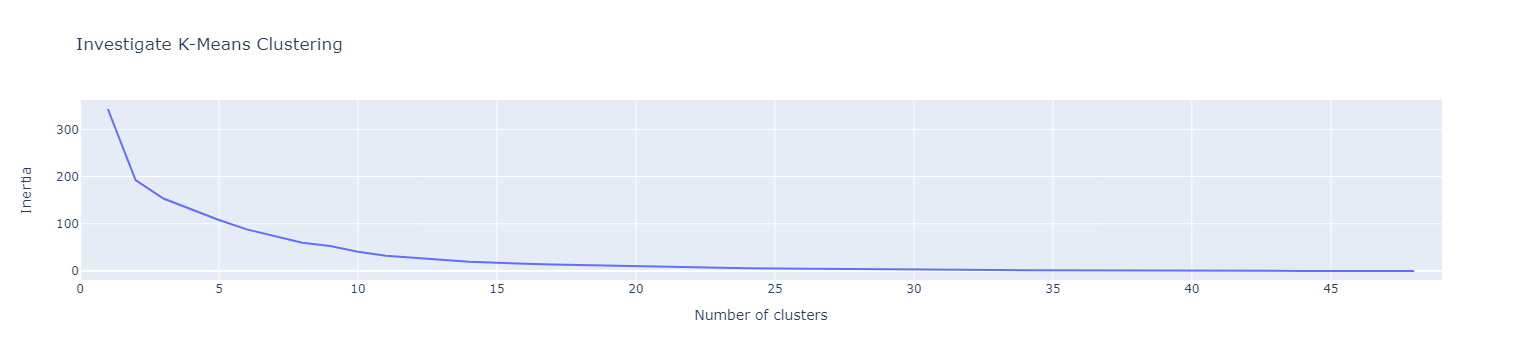

In [120]:
fig1 = go.Figure(data=go.Scatter(x=tuple(range(1, max_clusters)), y=inertias[1:]))

fig1.update_layout(go.Layout(title='Investigate K-Means Clustering',
                            xaxis=go.XAxis(title='Number of clusters',
                                            range=[0, max_clusters]),
                            yaxis=go.YAxis(title='Inertia')
))

fig1.show()

In [128]:
pca = PCA()
pca.fit(X_scaled);
var = list(np.cumsum(pca.explained_variance_ratio_))
var.insert(0,0)
var = [i * 100 for i in var]

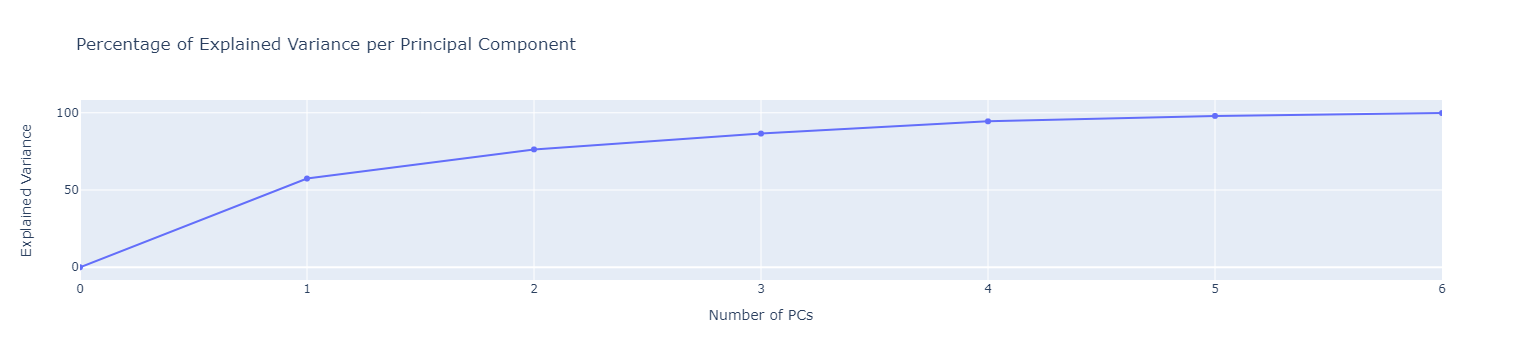

In [130]:
fig2 = go.Figure(data=go.Scatter(y=var))

fig2.update_layout(go.Layout(title='Percentage of Explained Variance per Principal Component',
                            xaxis=go.XAxis(title='Number of PCs', range=[0, 6]),
                            yaxis=go.YAxis(title='Explained Variance')
))

fig2.show()

In [19]:
#2020
warnings.filterwarnings('ignore')

clusterdf20, Z20, silhoutte20, ari20 = mda.cluster_algorithm(df20_processed, "KMeans")

def cluster_fig20(selection):
    import plotly.express as px
    
    title_dict = {"cases":"Cases",
                  "deaths":"Deaths",
                  "1_dose":"1 Vaccination Dose",
                  "complete_dose":"Complete Vaccinations"}
    
    fig20 = go.Figure(
    data=go.Scatter(
        x=clusterdf20["PC1"].values,
        y=clusterdf20["PC2"].values,
        text=clusterdf20.index,
        mode='markers',
        marker=go.Marker(
            size=df20_processed[selection],
            sizemode='diameter',
            sizeref=df20_processed[selection].max()/49,
            opacity=1,
            color=Z20
            )
        )
    )

    fig20.update_layout(
        go.Layout(
            title=f'US State Cluster Analysis 2020 (size represents {title_dict[selection]})',
            xaxis=go.XAxis(title="PC1", showgrid=True, zeroline=True, showticklabels=True),
            yaxis=go.YAxis(title="PC2", showgrid=True, zeroline=True, showticklabels=True),
            hovermode='closest'
        )
    )

    fig20.show()

widgets.interact(cluster_fig20,
                 selection=widgets.Dropdown(
                     options=[("Cases", "cases"),
                              ("Deaths", "deaths"),
                              ("1 Vaccination Dose", "1_dose"),
                              ("Complete Vaccinations", "complete_dose")],
                     description='Select:'));

interactive(children=(Dropdown(description='Select:', options=(('Cases', 'cases'), ('Deaths', 'deaths'), ('1 V…

In [20]:
#2021
warnings.filterwarnings('ignore')

clusterdf21, Z21, silhoutte21, ari21 = mda.cluster_algorithm(df21_processed, "KMeans")

def cluster_fig21(selection):
    import plotly.express as px
    
    title_dict = {"cases":"Cases",
                  "deaths":"Deaths",
                  "1_dose":"1 Vaccination Dose",
                  "complete_dose":"Complete Vaccinations"}
    
    fig21 = go.Figure(
    data=go.Scatter(
        x=clusterdf21["PC1"].values,
        y=clusterdf21["PC2"].values,
        text=clusterdf21.index,
        mode='markers',
        marker=go.Marker(
            size=df21_processed[selection],
            sizemode='diameter',
            sizeref=df21_processed[selection].max()/49,
            opacity=1,
            color=Z20
            )
        )
    )

    fig21.update_layout(
        go.Layout(
            title=f'US State Cluster Analysis 2021 (size represents {title_dict[selection]})',
            xaxis=go.XAxis(title="PC1", showgrid=True, zeroline=True, showticklabels=True),
            yaxis=go.YAxis(title="PC2", showgrid=True, zeroline=True, showticklabels=True),
            hovermode='closest'
        )
    )

    fig21.show()

widgets.interact(cluster_fig21,
                 selection=widgets.Dropdown(
                     options=[("Cases", "cases"),
                              ("Deaths", "deaths"),
                              ("1 Vaccination Dose", "1_dose"),
                              ("Complete Vaccinations", "complete_dose")],
                     description='Select:'));

interactive(children=(Dropdown(description='Select:', options=(('Cases', 'cases'), ('Deaths', 'deaths'), ('1 V…

In [21]:
#2022
warnings.filterwarnings('ignore')

clusterdf22, Z22, silhoutte22, ari22 = mda.cluster_algorithm(df22_processed, "KMeans")

def cluster_fig22(selection):
    import plotly.express as px
    
    title_dict = {"cases":"Cases",
                  "deaths":"Deaths",
                  "1_dose":"1 Vaccination Dose",
                  "complete_dose":"Complete Vaccinations"}
    
    fig22 = go.Figure(
    data=go.Scatter(
        x=clusterdf22["PC1"].values,
        y=clusterdf22["PC2"].values,
        text=clusterdf22.index,
        mode='markers',
        marker=go.Marker(
            size=df22_processed[selection],
            sizemode='diameter',
            sizeref=df22_processed[selection].max()/49,
            opacity=1,
            color=Z20
            )
        )
    )

    fig22.update_layout(
        go.Layout(
            title=f'US State Cluster Analysis 2022 (size represents {title_dict[selection]})',
            xaxis=go.XAxis(title="PC1", showgrid=True, zeroline=True, showticklabels=True),
            yaxis=go.YAxis(title="PC2", showgrid=True, zeroline=True, showticklabels=True),
            hovermode='closest'
        )
    )

    fig22.show()

widgets.interact(cluster_fig22,
                 selection=widgets.Dropdown(
                     options=[("Cases", "cases"),
                              ("Deaths", "deaths"),
                              ("1 Vaccination Dose", "1_dose"),
                              ("Complete Vaccinations", "complete_dose")],
                     description='Select:'));

interactive(children=(Dropdown(description='Select:', options=(('Cases', 'cases'), ('Deaths', 'deaths'), ('1 V…

One can see that on each of those graphs, a specific pattern arises.

States with higher number of cases/deaths/population score higher on the axis of PC1 whereas states with higher numbers of vaccinations score higher on the axis of PC2.

Generally with only several expeptions states that are geographically close tend to cluster together.

# Research Topic 2 (ANOVA Analysis):

The second analysis that we conducted is an ANOVA Analysis.

The goal was to study the effect of each month during the pandemic, and investigate if there was any difference between them.

The study was conducted only on the 2021 data as it is the only year that contained all 12 months.

In [22]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [23]:
anovadf = mda.anova_process(mapdf)

In [24]:
anova2020 = anovadf[anovadf["year"]==2020]
anova2021 = anovadf[anovadf["year"]==2021]
anova2022 = anovadf[anovadf["year"]==2022]

In [25]:
temp_df1 = anova2021.copy(deep=True)
temp_df1["month"]-=12
month_dict = {1:"January", 2:"February", 3:"March", 4:"April", 5:"May", 6:"June", 7:"July", 8:"August", 9:"September", 10:"October", 11:"November", 12:"December"}
temp_df1["month"] = temp_df1["month"].map(month_dict)

def fig_creator2(selection):
    import plotly.express as px
    
    title_dict = {"monthly_cases":"Monthly Cases",
                  "monthly_deaths":"Monthly Deaths",
                  "monthly_1dose":"Monthly Vaccination Dose",
                  "monthly_completedose":"Monthly Complete Vaccinations"}
    
    fig = px.strip(temp_df1, x='month', y=selection, color="state", title=f"{title_dict[selection]} per month in 2021",
                   hover_data=["monthly_cases", "monthly_deaths", "monthly_1dose", "monthly_completedose"],
                   labels={selection:title_dict[selection]})
    fig.show()

widgets.interact(fig_creator2,
                 selection=widgets.Dropdown(
                     options=[("Monthly Cases", "monthly_cases"),
                              ("Monthly Deaths", "monthly_deaths"),
                              ("Monthly Vaccination Dose", "monthly_1dose"),
                              ("Monthly Complete Vaccinations", "monthly_completedose")],
                     description='Select:'));

interactive(children=(Dropdown(description='Select:', options=(('Monthly Cases', 'monthly_cases'), ('Monthly D…

From the above graph we can see that monthly cases and deaths follow similar trend with higher numbers during the winter and autumn months (January, February, September, October) and lower numbers in spring and summer months (April-August). As for the vaccinations we see higher numbers during the spring months and this might explain the lower numbers of cases and deaths in those months.

In [26]:
temp_df2 = anova2021.copy(deep=True)
temp_df2["month"]-=12

def fig_creator3(selection1, selection2):
    import plotly.express as px
    
    title_dict = {"monthly_cases":"Monthly Cases",
                  "monthly_deaths":"Monthly Deaths",
                  "monthly_1dose":"Monthly Vaccination Dose",
                  "monthly_completedose":"Monthly Complete Vaccinations"}
    
    fig = px.scatter(temp_df2[temp_df2["state"]==selection2], x="month", y=selection1, trendline="ols",
                     title=f"{title_dict[selection1]} in {selection2} 2021",
                    labels={selection1:title_dict[selection1]})
    fig.show()

selection2_options = []
for s in anova2021["state"].unique():
    selection2_options.append((s,s))

widgets.interact(fig_creator3,
                 
                 selection1=widgets.Dropdown(
                     options=[("Monthly Cases", "monthly_cases"),
                              ("Monthly Deaths", "monthly_deaths"),
                              ("Monthly Vaccination Dose", "monthly_1dose"),
                              ("Monthly Complete Vaccinations", "monthly_completedose")],
                     description='Select:'),
                 
                 selection2=widgets.Dropdown(
                     options=selection2_options,
                     description='Select:'));

interactive(children=(Dropdown(description='Select:', options=(('Monthly Cases', 'monthly_cases'), ('Monthly D…

The above plot dives deeper into the association of cases/deaths/vaccination/complete vaccinations per month for each state individually and fits a rergession line.

In [27]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [48]:
temp_df3 = anova2021.copy(deep=True)
temp_df3 = temp_df3[["state", "year", "month", "monthly_cases", "monthly_deaths", "population"]]
temp_df3["month"]-=12
month_dict = {1:"January", 2:"February", 3:"March", 4:"April", 5:"May", 6:"June", 7:"July", 8:"August", 9:"September", 10:"October", 11:"November", 12:"December"}
temp_df3["month"] = temp_df3["month"].map(month_dict)
temp_df3["monthly_case_ratio"] = temp_df3["monthly_cases"]/temp_df3["population"]
temp_df3["monthly_death_ratio"] = temp_df3["monthly_deaths"]/temp_df3["population"]

In [50]:
tempdf_cases = temp_df3[["month", "monthly_cases", "monthly_case_ratio"]]
tempdf_cases["index"] = list(range(49))*12
tempdf_cases = tempdf_cases[["index", "month", "monthly_cases", "monthly_case_ratio"]]
tempdf_deaths = temp_df3[["month", "monthly_deaths", "monthly_death_ratio"]]
tempdf_deaths["index"] = list(range(49))*12
tempdf_deaths = tempdf_deaths[["index", "month", "monthly_deaths", "monthly_death_ratio"]]

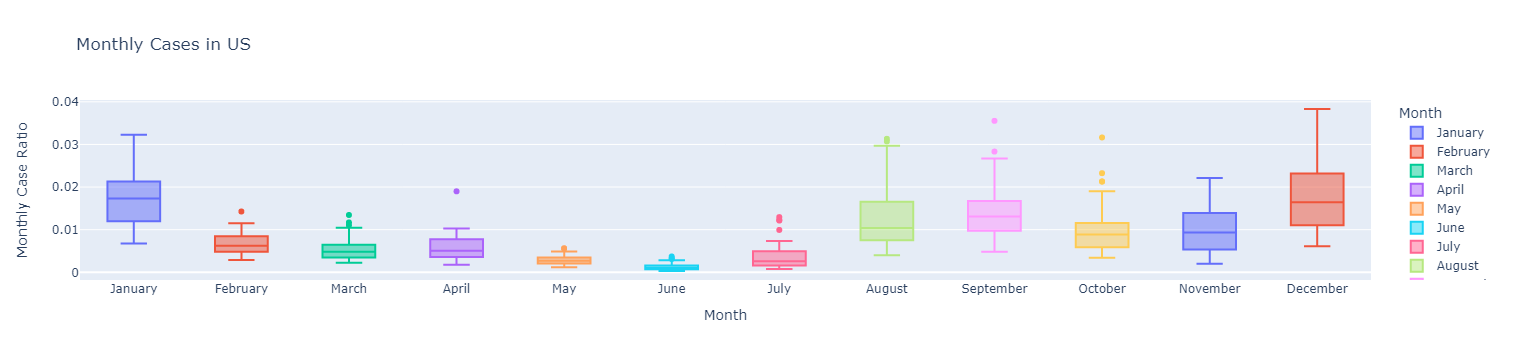

In [53]:
boxplot = px.box(tempdf_cases, x="month", y="monthly_case_ratio",
                 labels={"monthly_case_ratio":"Monthly Case Ratio", "month":"Month"},
                 color="month", title="Monthly Cases in US")
boxplot.show()

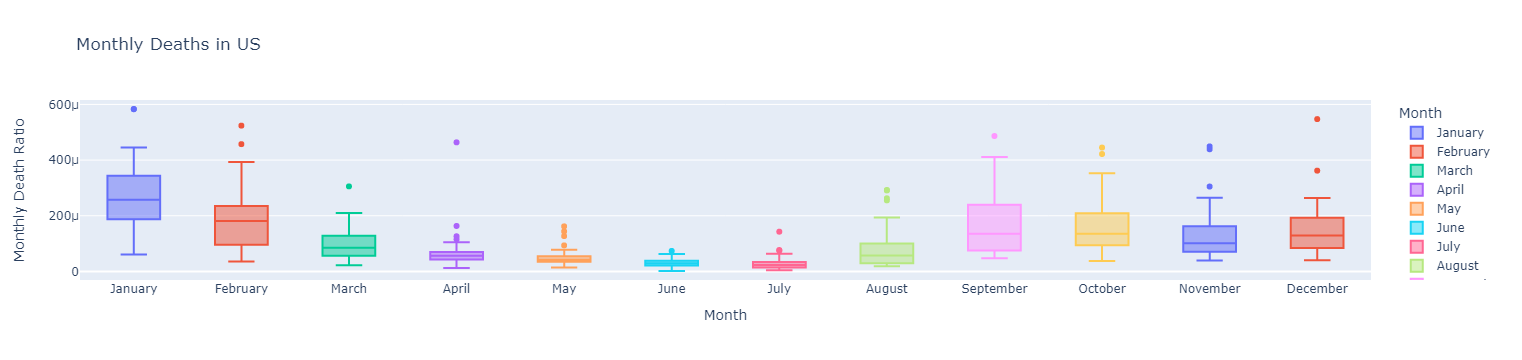

In [54]:
boxplot1 = px.box(tempdf_deaths, x="month", y="monthly_death_ratio",
                 labels={"monthly_death_ratio":"Monthly Death Ratio", "month":"Month"},
                 color="month", title="Monthly Deaths in US")
boxplot1.show()

The boxplots show the same results as the previosly seen swarm plot. Additionally we can see summary statistics (min, max, median, quantiles) for each month. As observed there are strong indications that there is an effect of month on the cases and deaths.

To formally test the effect of month on cases and deaths we performed ANOVA analysis.

In [55]:
# get ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Ordinary Least Squares (OLS) model
model_cases = ols('monthly_case_ratio ~ month', data=tempdf_cases).fit()
anova_table_cases = sm.stats.anova_lm(model_cases, typ=2)
anova_table_cases

,sum_sq,df,F,PR(>F)
month,0.016403,11.0,62.528566,7.954165e-91
Residual,0.013736,576.0,NaN,NaN


The p-value of the global F-statistic is highly significant indicating that indeed there are differences on the average cases per month. 

After rejecting the hypothesis of equal means across all 12 months we performed multiple pairwise comparisons using Tukey’s HSD procedur with gives us more insights into the differences between months. 

In [57]:
from bioinfokit.analys import stat
# perform multiple pairwise comparison (Tukey's HSD)
# unequal sample size data, tukey_hsd uses Tukey-Kramer test
res_cases = stat()
res_cases.tukey_hsd(df=tempdf_cases, res_var='monthly_case_ratio', xfac_var='month', anova_model='monthly_case_ratio ~ month')
res_cases.tukey_summary

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,January,February,0.010148,0.006910,0.013386,14.546535,0.001000
1,January,March,0.011324,0.008087,0.014562,16.232282,0.001000
2,January,April,0.011175,0.007937,0.014413,16.018111,0.001000
3,January,May,0.013924,0.010686,0.017161,19.958214,0.001000
4,January,June,0.015545,0.012307,0.018782,22.281995,0.001000
...,...,...,...,...,...,...,...
61,September,November,0.004233,0.000995,0.007471,6.067658,0.001252
62,September,December,0.003455,0.000217,0.006693,4.952230,0.024832
63,October,November,0.000061,-0.003177,0.003298,0.086895,0.900000
64,October,December,0.007748,0.004511,0.010986,11.106783,0.001000


The following table shows the results of the ANOVA analysis for the deaths. The p-value of the global F-statistic is highly significant indicating that indeed there are differences on the average deaths per month. 

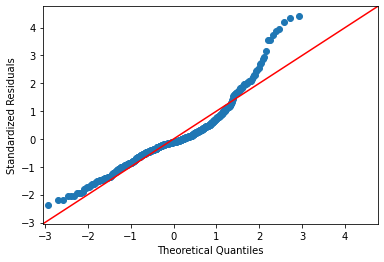

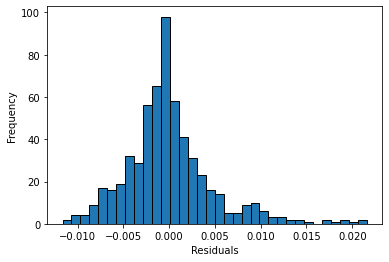

In [58]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
# res.anova_std_residuals are standardized residuals obtained from ANOVA (check above)
sm.qqplot(res_cases.anova_std_residuals, line='45')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.show()

# histogram
plt.hist(res_cases.anova_model_out.resid, bins='auto', histtype='bar', ec='k') 
plt.xlabel("Residuals")
plt.ylabel('Frequency')
plt.show()

In [59]:
model_deaths = ols('monthly_death_ratio ~ month', data=tempdf_deaths).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
month,1.458479e+08,11.0,7.843796,9.368774e-13
Residual,9.736517e+08,576.0,NaN,NaN


After rejecting the hypothesis of equal means across all 12 months we performed multiple pairwise comparisons using Tukey’s HSD procedur with gives us more insights into the differences between months. 

In [60]:
from bioinfokit.analys import stat
# perform multiple pairwise comparison (Tukey's HSD)
# unequal sample size data, tukey_hsd uses Tukey-Kramer test
res_deaths = stat()
res_deaths.tukey_hsd(df=tempdf_deaths, res_var='monthly_death_ratio', xfac_var='month', anova_model='monthly_death_ratio ~ month')
res_deaths.tukey_summary

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,January,February,0.000082,0.000029,0.000135,7.155419,0.001000
1,January,March,0.000174,0.000121,0.000227,15.207387,0.001000
2,January,April,0.000202,0.000149,0.000255,17.637408,0.001000
3,January,May,0.000219,0.000166,0.000272,19.124378,0.001000
4,January,June,0.000239,0.000186,0.000293,20.901637,0.001000
...,...,...,...,...,...,...,...
61,September,November,0.000037,-0.000017,0.000090,3.190912,0.508000
62,September,December,0.000017,-0.000036,0.000070,1.500182,0.900000
63,October,November,0.000028,-0.000025,0.000081,2.442655,0.838459
64,October,December,0.000009,-0.000045,0.000062,0.751925,0.900000


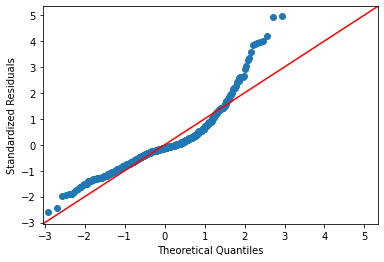

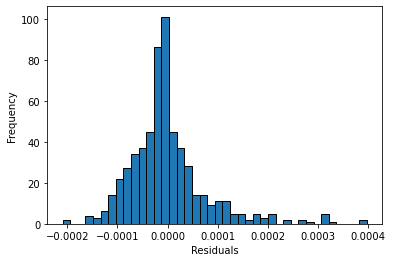

In [61]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
# res.anova_std_residuals are standardized residuals obtained from ANOVA (check above)
sm.qqplot(res_deaths.anova_std_residuals, line='45')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.show()

# histogram
plt.hist(res_deaths.anova_model_out.resid, bins='auto', histtype='bar', ec='k') 
plt.xlabel("Residuals")
plt.ylabel('Frequency')
plt.show()

# Research Topic 3 (Time Series):
Lastly, we wanted to investigate the daily changes in cases and deaths due to COVID-19. Thus we computed the daily differences in cases and deaths. This was done at the country level, for each state as well as for each county.

This daily change is shown in the next graph where one can switch between the different levels investigated.

In [36]:
dropdown_case = widgets.Dropdown(options=[("Daily Cases", 'daily_cases'), ("Daily Deaths", 'daily_deaths')])
dropdown_level = widgets.Dropdown(options=[('USA','us'),('State','state'), ('County','county')])
dropdown_state = widgets.Dropdown(options=state_timeseries['state'].unique())
dropdown_county = widgets.Dropdown(options=counties_timeseries['county'].unique())
input_widgets = widgets.HBox([dropdown_case, dropdown_level])

output = widgets.Output()
def com_filter(case, level, state, county):
    output.clear_output()
    if level == 'us':
        with output:
            mda.plot(us_timeseries, level="us", y=case)
    elif level == "state":
        with output:
            display(dropdown_state)
            mda.plot(state_timeseries, level="state", y=case, state=state)
    elif level == "county":
        with output:
            display(dropdown_county)
            mda.plot(counties_timeseries, level="county", y=case, county=county)

def dropdown_case_eventhandler(change):
    com_filter(change.new, dropdown_level.value, dropdown_state.value, dropdown_county.value)

def dropdown_level_eventhandler(change):
    com_filter(dropdown_case.value, change.new, dropdown_state.value, dropdown_county.value)    
    
def dropdown_state_eventhandler(change):
    com_filter(dropdown_case.value, dropdown_level.value, change.new, dropdown_county.value)
    
def dropdown_county_eventhandler(change):
    com_filter(dropdown_case.value, dropdown_level.value, dropdown_state.value, change.new)
    
dropdown_case.observe(dropdown_case_eventhandler, names='value')
dropdown_level.observe(dropdown_level_eventhandler, names='value')
dropdown_state.observe(dropdown_state_eventhandler, names='value')
dropdown_county.observe(dropdown_county_eventhandler, names='value')
display(input_widgets)
display(output)

#initial plot
with output:
    mda.plot(us_timeseries, level="us", y='daily_cases')

Output()

One interesting thing to take for those graphs is that most places in the US saw their highest number of COVID-19 cases happen in January 2022.

Moreover, we did investigate if the COVID-19 cases had any seasonal pattern, and was following some trends. The results from that are shown below. 

It is clear that there is a seasonality effect of the COVID-19 pandemics, which was to be expected as we established that there was a month effect when doing the ANOVA analysis. The cases tend to spike up during the winter months, more specifically from October till February and decreases over summer, from
March/April till September.

Regarding the trend, the daily cases follow an upward trend with bumps here and there


In [37]:
#Trend and Seasonality in the US
usa_time = us_timeseries.set_index('date')
usa_time.dropna(inplace=True)
decompose_result_mult = seasonal_decompose(usa_time['daily_cases'],period=365)
trend = decompose_result_mult.trend
seasonality = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

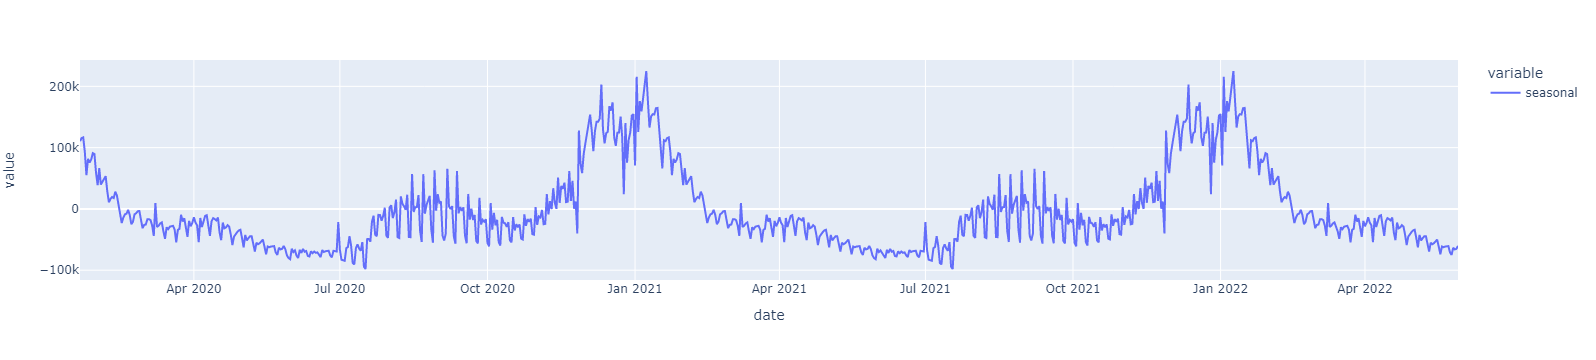

In [38]:
px.line(seasonality)

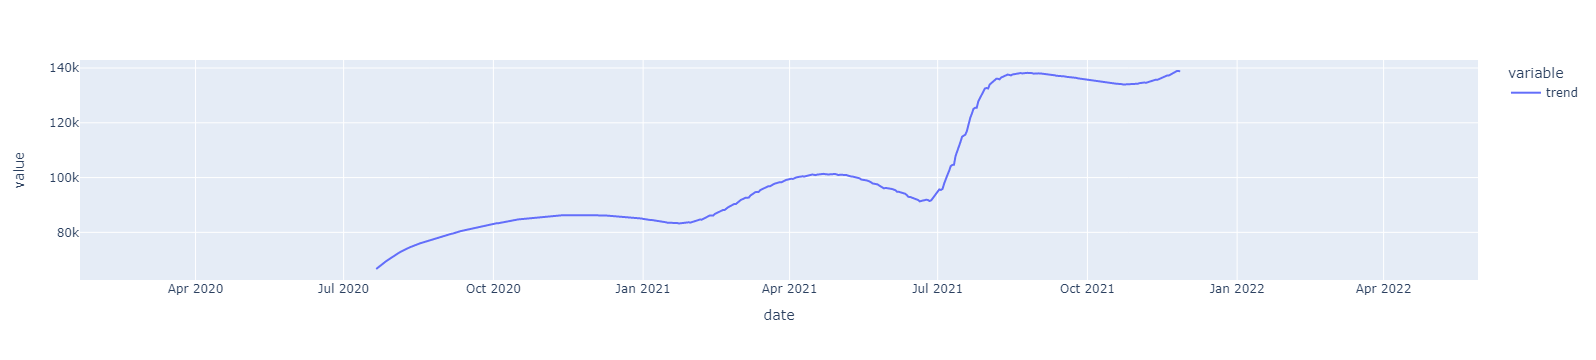

In [39]:
px.line(trend)

# Case 1 (Effect of pandemic on stocks)
An investigation of the impact of the main events of COVID-19 on two main stocks is conducted here. The motivation for this case study was to investigate how big of an impact the pandemic hadon stocks. For this, the S&P 500 and the Nasdaq-100 indexes were chosen. They were chosen because they are two of the largest indexes in the US and are amongst the most followed equity indices. 



The data used for this study case was retrieved using the yahoo finance API. (yfinance) 

In [40]:
start_date = us_timeseries['date'].min()
end_date = us_timeseries['date'].max()
stocks = mda.get_stocks('^GSPC','^NDX',start_date,end_date,'sp500','nasdaq')
dfsp500 = stocks[0]
dfndx = stocks[1]
dfstocks = stocks[2]

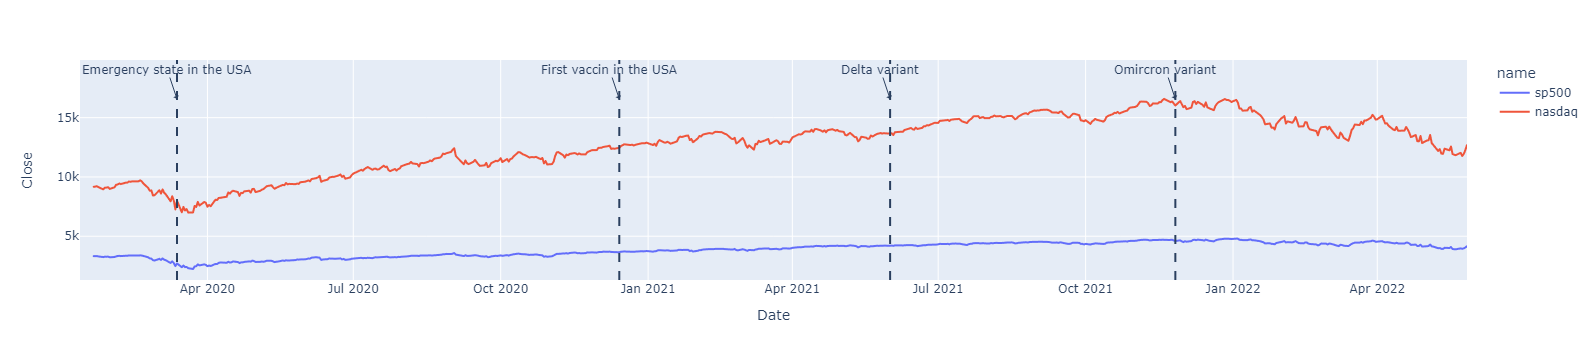

In [41]:
max_y =dfstocks['Close'].max()
fig = px.line(dfstocks,y= 'Close' ,color='name')
fig.add_vline(x='2020-03-13',line_dash="dash") #emergency state in the USA
fig.add_vline(x='2020-12-14',line_dash="dash") #first vaccine in the USA
fig.add_vline(x='2021-06-01',line_dash="dash") #delta variant
fig.add_vline(x='2021-11-26',line_dash="dash") #omicron variant
fig.add_annotation(x='2020-03-13', y=max_y,
            text="Emergency state in the USA",
            showarrow=True,
            arrowhead=1)
fig.add_annotation(x='2020-12-14', y=max_y,
            text="First vaccin in the USA",
            showarrow=True,
            arrowhead=1)
fig.add_annotation(x='2021-06-01', y=max_y,
            text="Delta variant",
            showarrow=True,
            arrowhead=1)
fig.add_annotation(x='2021-11-26', y=max_y,
            text="Omircron variant",
            showarrow=True,
            arrowhead=1)

In [42]:
ndx_changes = mda.changes(dfndx,['2020-03-13','2020-12-14','2021-06-01','2021-11-26'])
sp500_changes = mda.changes(dfsp500,['2020-03-13','2020-12-14','2021-06-01','2021-11-26'])

In [43]:
md("The declaration of the emergency state had a big impact on both s&p500 and nasdaq stock as their values were down by  {}% and {}% respectively. Neither the first vaccin nor the arrival of the delta variant seem to have had an impact   as both stayed on the same trend. The Omicron variant has a small impact on both as their values were down by {}% and {}% after 7 days of the first case."
   .format(round(ndx_changes[0],3),round(sp500_changes[0],3), round(ndx_changes[3],2),round(sp500_changes[3],2)))

The declaration of the emergency state had a big impact on both s&p500 and nasdaq stock as their values were down by  -12.52% and -14.98% respectively. Neither the first vaccin nor the arrival of the delta variant seem to have had an impact   as both stayed on the same trend. The Omicron variant has a small impact on both as their values were down by -1.96% and -1.22% after 7 days of the first case.

Both equities seem to follow an upward trend throughout the entire pandemic. Thus it can be concluded that except for the emergency state, no COVID-19 related events had much impact on those two stocks values